In [65]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from scipy.stats import skew

pd.options.display.max_columns = 500

Снова потренируемся в предсказании цен на недвижимость из [очередного датасета с каггла](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/)! В качестве основной метрики для валидации моделей будем использовать, как и ранее, `MSLE`.

P.S. в данной домашней работе при построении любых моделей, использующих недетерменированные элементы (как бутстрап), в алгоритме указывайте параметр `random_state = 1` для воспроизводимости результатов.

In [96]:
df = (
    pd.read_csv('data.csv')
    .drop('Id', axis=1)
)

df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,

In [101]:
### Разделим выборку на объекты-таргеты

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

### Логарифмируем таргет для будущей оптимизации
### MSLE через MSE

log_target = np.log1p(y)

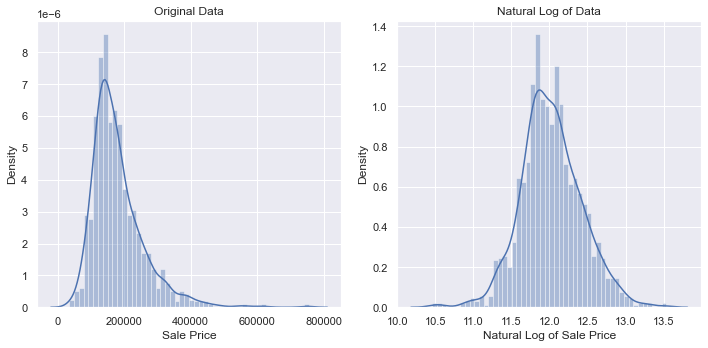

In [67]:
### Это позволяет получить нормальное распределение таргета
### Важно, например, для построения корректной
### С точки зрения статистических свойств
### Линейной модели.
### Хотя здесь мы будем строить ансамбли деревьев, 
### И это не особо интересно.

sns.set(rc={'figure.figsize':(15,10)})

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(y, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(log_target, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

### В начале поработаем с пропусками!

Если в какой-либо колонке оказывается достаточно много пропусков, обычно советуют от них избавляться. Мотивировано это тем, что в таких фичах мы можем наблюдать серьезный недостаток информативности, а заполнение пропусков может лишь внести лишнего шума в данные.

Избавьтесь от всех колонок, в которых пропусков оказывается больше 15%. (1б)

In [102]:
perc = 15.0
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
X = X.dropna( axis=1,
                thresh=min_count)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Вещественные колонки заполните медианным значением по фиче, а категориальные - самой популярной по колонке категорией. (2б)

Заметьте, что колонки `MoSold`, `YrSold`, `GarageYrBlt`, `YearBuilt`, `YearRemodAdd` хоть в таблице не являются типами `object`, вряд ли их справедливо использовать как вещественные. Обработайте их как категориальные, а затем переведите в строки.

In [103]:
df_numeric_col = X.loc[:,X.dtypes!=np.object].columns
df_categorical_col = X.loc[:,X.dtypes==np.object].columns

for col in df_numeric_col:
    median = X.loc[:, col].median()
    X.loc[:, col].fillna(median, inplace=True)

for col in df_categorical_col:
    popular = X[col].value_counts().idxmax()
    X.loc[:, col].fillna(popular, inplace=True)

object_cols = ['MoSold', 'YrSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']
X[object_cols] = X[object_cols].astype(object)


In [104]:
X.isna().sum()

MSSubClass       0
MSZoning         0
LotArea          0
Street           0
LotShape         0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 73, dtype: int64

In [155]:
### Отложенная выборка

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    log_target, 
                                                    test_size=0.25, 
                                                    random_state=15)

Напишите трансформер, который будет делать следующее:

1. Масштабирование через StandardScaler для вещественных колонок
2. Кодирование через OneHotEncoder для категориальных, содержащих менее, чем 5 уникальных значений
3. Кодирование через TargetEncoder для всех остальных категориальных

Для этого советуем воспользоваться библиотекой `category_encoders` помимо `sklearn`.

А так же классом `ColumnTransformer` из `sklearn.compose`.

P.S. Напомним, что для деревьев процедура StandardScaling не обязательна (решающие деревья нечувствительны к масштабу). Тем не менее, это может сделать обучение модели менее тяжелым (хранить большие числа сложно для задач с большим количеством данных).

In [130]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

numeric_cols = list(X_train.select_dtypes(exclude='object').columns)
cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]

numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_cols]
cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

In [131]:
t = [('StandardScaler', StandardScaler(), numeric_cols_idx),
     ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
     ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)]

col_transform = ColumnTransformer(transformers=t)

In [133]:
col_transform.fit(X_train, y_train)

ColumnTransformer(transformers=[('StandardScaler', StandardScaler(),
                                 [0, 2, 14, 15, 23, 31, 33, 34, 35, 40, 41, 42,
                                  43, 44, 45, 46, 47, 48, 49, 51, 53, 57, 58,
                                  62, 63, 64, 65, 66, 67, 68]),
                                ('OneHotEncoder', OneHotEncoder(), []),
                                ('MeanTargetEncoder', TargetEncoder(),
                                 [69, 70, 55, 16, 17])])

Посмотрите, как на наших данных справляется одно Решающее Дерево с дефолтными гиперпараметрами. Добавьте написанный ранее трансформер в модель. (1б)

In [146]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe_dt = Pipeline([("column_transformer",
                     col_transform),

                    ("decision_tree",
                     DecisionTreeRegressor(random_state=1))])

pipe_dt.fit(X_train, y_train)

train_preds = pipe_dt.predict(X_train)
test_preds = pipe_dt.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")


Качество на трейне: 0.0
Качество на тесте: 0.045


Справляется даже без контроля переобучения!

Посмотрим на перформанс Случайного Леса! Подберите параметры по отложенной выборке по данной сетке `param_grid`. Помните, что подбирать количество деревьев не супер обязательно, достаточно поставить их побольше. Что произошло с качеством модели по сравнению с одиноким деревом? (2б)

In [156]:
param_grid = {
    "decision_tree__max_depth": [10, 15, 20],
    "decision_tree__min_samples_split": [2, 5, 10],
    "decision_tree__min_samples_leaf": [1, 3, 5]
}

pipe_rf = Pipeline([("column_transformer",
                               col_transform),

                              ("decision_tree",
                               RandomForestRegressor(max_depth=10,
                                                     verbose=1))])

search = GridSearchCV(pipe_rf,
                      param_grid,
                      scoring='neg_mean_squared_error',
                      verbose=10)

search.fit(X_train, y_train)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y_test):.3f}")



Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 1/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.018 total time=   0.4s
[CV 2/5; 1/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 1/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.031 total time=   0.4s
[CV 3/5; 1/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 1/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.023 total time=   0.5s
[CV 4/5; 1/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 1/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.030 total time=   0.4s
[CV 5/5; 1/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 1/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.028 total time=   0.4s
[CV 1/5; 2/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 2/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.019 total time=   0.4s
[CV 2/5; 2/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 2/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.031 total time=   0.4s
[CV 3/5; 2/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 2/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.024 total time=   0.4s
[CV 4/5; 2/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 2/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.030 total time=   0.4s
[CV 5/5; 2/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 2/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.029 total time=   0.4s
[CV 1/5; 3/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 3/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.018 total time=   0.4s
[CV 2/5; 3/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 3/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.030 total time=   0.4s
[CV 3/5; 3/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 3/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.025 total time=   0.4s
[CV 4/5; 3/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 3/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.031 total time=   0.4s
[CV 5/5; 3/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 3/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.028 total time=   0.4s
[CV 1/5; 4/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 4/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.018 total time=   0.4s
[CV 2/5; 4/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 4/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.030 total time=   0.4s
[CV 3/5; 4/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 4/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.025 total time=   0.4s
[CV 4/5; 4/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 4/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.030 total time=   0.4s
[CV 5/5; 4/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 4/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.030 total time=   0.4s
[CV 1/5; 5/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 5/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.018 total time=   0.4s
[CV 2/5; 5/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 5/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.030 total time=   0.4s
[CV 3/5; 5/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 5/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.024 total time=   0.4s
[CV 4/5; 5/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 5/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.030 total time=   0.4s
[CV 5/5; 5/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 5/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.029 total time=   0.4s
[CV 1/5; 6/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 6/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.019 total time=   0.4s
[CV 2/5; 6/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 6/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.030 total time=   0.4s
[CV 3/5; 6/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 6/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.024 total time=   0.4s
[CV 4/5; 6/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 6/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.031 total time=   0.4s
[CV 5/5; 6/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 6/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.029 total time=   0.3s
[CV 1/5; 7/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 7/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.018 total time=   0.3s
[CV 2/5; 7/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 7/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.029 total time=   0.3s
[CV 3/5; 7/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 7/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.024 total time=   0.3s
[CV 4/5; 7/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 7/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.031 total time=   0.3s
[CV 5/5; 7/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 7/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.030 total time=   0.3s
[CV 1/5; 8/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 8/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.018 total time=   0.3s
[CV 2/5; 8/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 8/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.029 total time=   0.3s
[CV 3/5; 8/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 8/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.025 total time=   0.3s
[CV 4/5; 8/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 8/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.031 total time=   0.3s
[CV 5/5; 8/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 8/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.031 total time=   0.3s
[CV 1/5; 9/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 9/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.018 total time=   0.3s
[CV 2/5; 9/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 9/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.028 total time=   0.3s
[CV 3/5; 9/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 9/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.025 total time=   0.3s
[CV 4/5; 9/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 9/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.030 total time=   0.3s
[CV 5/5; 9/27] START decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 9/27] END decision_tree__max_depth=10, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.031 total time=   0.3s
[CV 1/5; 10/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 10/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.017 total time=   0.4s
[CV 2/5; 10/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 10/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.031 total time=   0.5s
[CV 3/5; 10/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 10/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.025 total time=   0.5s
[CV 4/5; 10/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 10/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.030 total time=   0.4s
[CV 5/5; 10/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 10/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.027 total time=   0.5s
[CV 1/5; 11/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 11/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.018 total time=   0.4s
[CV 2/5; 11/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 11/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.031 total time=   0.4s
[CV 3/5; 11/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 11/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.024 total time=   0.4s
[CV 4/5; 11/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 11/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.030 total time=   0.4s
[CV 5/5; 11/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 11/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.028 total time=   0.4s
[CV 1/5; 12/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 12/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.018 total time=   0.4s
[CV 2/5; 12/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 12/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.031 total time=   0.4s
[CV 3/5; 12/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 12/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.024 total time=   0.4s
[CV 4/5; 12/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 12/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.030 total time=   0.4s
[CV 5/5; 12/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 12/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.028 total time=   0.4s
[CV 1/5; 13/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 13/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.018 total time=   0.4s
[CV 2/5; 13/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 13/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.030 total time=   0.4s
[CV 3/5; 13/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 13/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.024 total time=   0.4s
[CV 4/5; 13/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 13/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.030 total time=   0.4s
[CV 5/5; 13/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 13/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.028 total time=   0.4s
[CV 1/5; 14/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 14/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.018 total time=   0.4s
[CV 2/5; 14/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 14/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.030 total time=   0.4s
[CV 3/5; 14/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 14/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.024 total time=   0.4s
[CV 4/5; 14/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 14/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.030 total time=   0.4s
[CV 5/5; 14/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 14/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.029 total time=   0.4s
[CV 1/5; 15/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 15/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.018 total time=   0.3s
[CV 2/5; 15/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 15/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.031 total time=   0.3s
[CV 3/5; 15/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 15/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.024 total time=   0.3s
[CV 4/5; 15/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 15/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.030 total time=   0.3s
[CV 5/5; 15/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 15/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.029 total time=   0.3s
[CV 1/5; 16/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 16/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.018 total time=   0.3s
[CV 2/5; 16/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 16/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.029 total time=   0.3s
[CV 3/5; 16/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 16/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.024 total time=   0.3s
[CV 4/5; 16/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 16/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.030 total time=   0.3s
[CV 5/5; 16/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 16/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.031 total time=   0.3s
[CV 1/5; 17/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 17/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.018 total time=   0.3s
[CV 2/5; 17/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 17/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.029 total time=   0.3s
[CV 3/5; 17/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 17/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.024 total time=   0.3s
[CV 4/5; 17/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 17/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.030 total time=   0.3s
[CV 5/5; 17/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 17/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.031 total time=   0.3s
[CV 1/5; 18/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 18/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.018 total time=   0.3s
[CV 2/5; 18/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 18/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.029 total time=   0.3s
[CV 3/5; 18/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 18/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.025 total time=   0.3s
[CV 4/5; 18/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 18/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.030 total time=   0.3s
[CV 5/5; 18/27] START decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 18/27] END decision_tree__max_depth=15, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.030 total time=   0.3s
[CV 1/5; 19/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 19/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.017 total time=   0.5s
[CV 2/5; 19/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 19/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.031 total time=   0.5s
[CV 3/5; 19/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 19/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.024 total time=   0.5s
[CV 4/5; 19/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 19/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.029 total time=   0.5s
[CV 5/5; 19/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 19/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=2;, score=-0.028 total time=   0.5s
[CV 1/5; 20/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 20/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.018 total time=   0.4s
[CV 2/5; 20/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 20/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.031 total time=   0.4s
[CV 3/5; 20/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 20/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.024 total time=   0.4s
[CV 4/5; 20/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 20/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.030 total time=   0.4s
[CV 5/5; 20/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 20/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=5;, score=-0.027 total time=   0.4s
[CV 1/5; 21/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 21/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.019 total time=   0.4s
[CV 2/5; 21/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 21/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.030 total time=   0.4s
[CV 3/5; 21/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 21/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.024 total time=   0.4s
[CV 4/5; 21/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 21/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.030 total time=   0.4s
[CV 5/5; 21/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 21/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=1, decision_tree__min_samples_split=10;, score=-0.028 total time=   0.4s
[CV 1/5; 22/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 22/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.018 total time=   0.4s
[CV 2/5; 22/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 22/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.031 total time=   0.4s
[CV 3/5; 22/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 22/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.024 total time=   0.4s
[CV 4/5; 22/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 22/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.030 total time=   0.4s
[CV 5/5; 22/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 22/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=2;, score=-0.030 total time=   0.4s
[CV 1/5; 23/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 23/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.018 total time=   0.4s
[CV 2/5; 23/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 23/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.031 total time=   0.4s
[CV 3/5; 23/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 23/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.024 total time=   0.4s
[CV 4/5; 23/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 23/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.030 total time=   0.4s
[CV 5/5; 23/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 23/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=5;, score=-0.029 total time=   0.4s
[CV 1/5; 24/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 24/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.019 total time=   0.3s
[CV 2/5; 24/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 24/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.029 total time=   0.4s
[CV 3/5; 24/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 24/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.024 total time=   0.4s
[CV 4/5; 24/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 24/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.031 total time=   0.4s
[CV 5/5; 24/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 24/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=3, decision_tree__min_samples_split=10;, score=-0.029 total time=   0.4s
[CV 1/5; 25/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 25/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.019 total time=   0.3s
[CV 2/5; 25/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 25/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.029 total time=   0.3s
[CV 3/5; 25/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 25/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.025 total time=   0.3s
[CV 4/5; 25/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 25/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.030 total time=   0.3s
[CV 5/5; 25/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 25/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=2;, score=-0.030 total time=   0.3s
[CV 1/5; 26/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 26/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.019 total time=   0.3s
[CV 2/5; 26/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 26/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.029 total time=   0.3s
[CV 3/5; 26/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 26/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.025 total time=   0.3s
[CV 4/5; 26/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 26/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.031 total time=   0.3s
[CV 5/5; 26/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 26/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=5;, score=-0.031 total time=   0.3s
[CV 1/5; 27/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/5; 27/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.019 total time=   0.3s
[CV 2/5; 27/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 2/5; 27/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.029 total time=   0.3s
[CV 3/5; 27/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 3/5; 27/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.025 total time=   0.3s
[CV 4/5; 27/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/5; 27/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.031 total time=   0.3s
[CV 5/5; 27/27] START decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 5/5; 27/27] END decision_tree__max_depth=20, decision_tree__min_samples_leaf=5, decision_tree__min_samples_split=10;, score=-0.030 total time=   0.3s
Best parameter (CV score=-0.02584):
{'decision_tree__max_depth': 20, 'decision_tree__min_samples_leaf': 1, 'decision_tree__min_samples_split': 2}
Качество лучшей модели на финальном тесте: -0.022


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Попробуем теперь поэкспериментировать с бэггингами. 

Постройте бэггинги с 100 базовыми моделями (и остальными стандартными параметрами) над линейной регрессией, деревом и случайным лесом (бэггинг над бэггингом!). 

Какое качество у каждой модели на тесте?

Какой алгоритм получился лучше с точки зрения качества на тесте? (2б)

In [153]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

line = BaggingRegressor(LinearRegression(),
                        n_estimators=100,
                        random_state=1, n_jobs = -1)

pipe_3 = Pipeline([('columns_transformer', col_transform),
                   ('linear_regression', line)])

pipe_3.fit(X_train, y_train)
print(f'Качество на тесте для LinearRegression: {mse(y_test, pipe_3.predict(X_test)).round(3)}')



Качество на тесте для LinearRegression: 0.022


Улучшил ли бэггинг над Лесом качество по сравнению с одним Лесом с точки зрения как качества на тесте, так и на трейне. Как это можно объяснить? Как думаете, много ли смысла в использовании бэггинга над линейными моделями? Выбрали бы вы в данной ситуации именно их в качестве базовых?

### Добавим новые фичи!

Создайте следующие четыре новые вещественные фичи:

1. Отношения площади 1 этажа к общей площади (колонки 1stFlrSF и GrLivArea, в %)
2. Отношение Площади завершенного фундамента первого типа к общей площади фундамента (колонки BsmtFinSF1 и TotalBsmtSF, в %)
3. Возраст дома (между YearBuilt и YrSold)
4. Общая площадь самого дома и фундамента/цоколя (1stFlrSF + 2ndFlrSF + TotalBsmtSF)

Обучите заново Случайный лес и найдите лучшие гиперпараметры на старой сетке.

Улучшили ли качество модели новые фичи? (4б)

In [154]:
### Your code is here
X['1stFlrSF_to_GrLivArea'] = (X['1stFlrSF'] / X['GrLivArea']) * 100
X['BsmtFinSF1_to_TotalBsmtSF'] = (X['BsmtFinSF1'] / X['TotalBsmtSF']) * 100
X['YearBuilt_to_YrSold'] = X['YearBuilt'] - X['YrSold']
X['1stFlrSF_plus_2ndFlrSF_plus_TotalBsmtSF'] = X['1stFlrSF'] + X['2ndFlrSF'] + X['TotalBsmtSF']



In [158]:
X['1stFlrSF_to_GrLivArea']

0        50.058480
1       100.000000
2        51.511758
3        55.969715
4        52.092812
           ...    
1455     57.862781
1456    100.000000
1457     50.769231
1458    100.000000
1459    100.000000
Name: 1stFlrSF_to_GrLivArea, Length: 1460, dtype: float64